In [5]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import OptimizeResult

from core import approx
from core.gradient_descent import steepest_descent
from core.high_order_optimization import newton_optimize, LBFGSNewtonDirectionApproximator, gauss_newton, dogleg, \
    BFGSNewtonDirectionApproximator
from core.utils import mesuare_time, plot_approx
%load_ext autoreload
%autoreload 2

from core.optimizer_evaluator import *
from core.abstract_analzyer import *
import scipy
import torch.optim
import torch
import math
from numpy.polynomial import Polynomial


# Сравнение `scipy.optimize.minimize` и `scipy.optimize.least_squares` с нашими методами

In [6]:
def steps(iters):
    return lambda f, ps: len(ps) > iters

x = torch.linspace(-math.pi, math.pi, 200)
y = torch.sin(x)

nx = x.numpy()
ny = y.numpy()
noise = np.random.normal(0, 0.1, (ny.size,))
ny += noise

handmade result = [ 1.68882795e-02  1.02389120e+00 -2.69728498e-02 -1.76922424e-01
  8.94567394e-03  9.55639178e-03 -7.31194611e-04 -2.10591563e-04], time = 0.20905828475952148s


[]

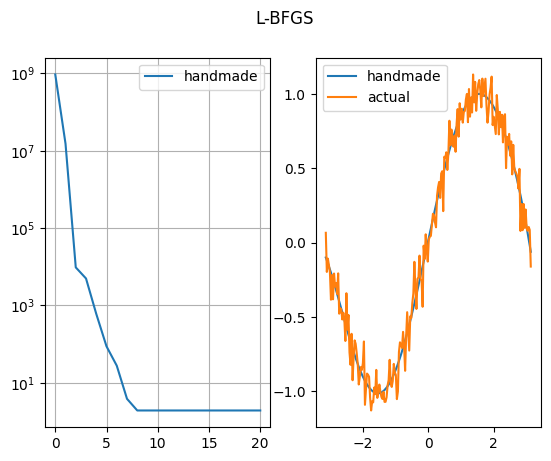

In [7]:
dump2, t = mesuare_time(lambda:
                        approx.polynom_approx(
                            nx, ny, 8,
                            lambda r, dr, f, df, x0: newton_optimize(f, df, LBFGSNewtonDirectionApproximator(10), x0, fibonacci_search(200), steps(20))
                        )
                        )
print(f"handmade result = {dump2.w}, time = {t}s")

plot_approx(nx, ny, [dump2]).suptitle('L-BFGS')
plt.plot()

scipy result = [ 2.93488419e-03  9.28844397e-01  1.81771242e-01  1.96320019e-01
 -4.58300026e-01 -5.13052317e-01  3.94470834e-01  3.68304238e-01
 -1.65765883e-01 -1.46453431e-01  3.84608615e-02  3.44089222e-02
 -5.11109643e-03 -4.83417971e-03  3.80247013e-04  3.95126739e-04
 -1.42719701e-05 -1.71241353e-05  1.96874239e-07  2.99007796e-07], time = 0.289064884185791s


[]

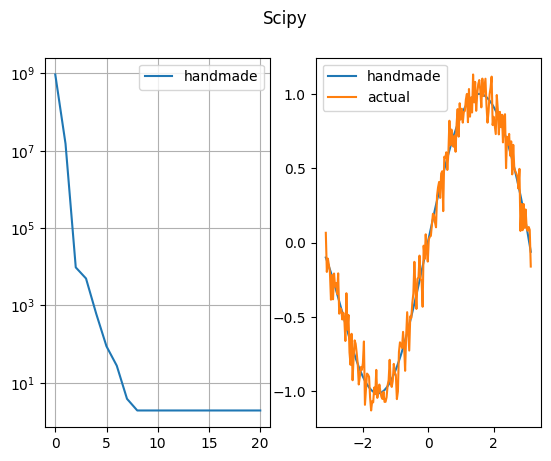

In [32]:
from core.abstract_analzyer import Algorithm, scipy_ls_point_number_and_time_extractor, LeastSquaresProblem, \
    scipy_ls_param_extractor, exp_pattern, exp_pattern_grad, exp_p0, noisify

sp_ls = Algorithm.sp_least_squares(scipy_ls_param_extractor, "trf")
problem = LeastSquaresProblem.polynom_approx(nx, ny, 20, (-10, 10))
params, t = mesuare_time(lambda: sp_ls.solve(problem))

print(f"scipy result = {params}, time = {t}s")

plot_approx(nx, ny, [dump2]).suptitle('Scipy')
plt.plot()

scipy result = [-0.92513166 -0.47865651  3.01619571 -2.1406314 ], time = 0.057015180587768555s


[]

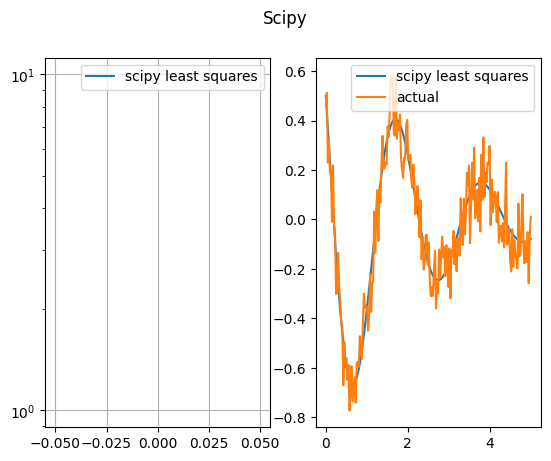

In [34]:
x = np.linspace(0, 5, 200)
y = noisify(exp_pattern(exp_p0)(x), 0.1)
problem = constrained_exp(x, np.array([10, 1, 10, 10]), y)

params, t = mesuare_time(lambda: sp_ls.solve(problem))

print(f"scipy result = {params}, time = {t}s")

plot_approx(x, y, [approx.ApproxDump.dumb("scipy least squares", x, params)], exp_pattern).suptitle('Scipy')
plt.plot()

# Сравнение оптимизаторов (пункт 2.a)


$${\displaystyle f({\boldsymbol {x}})=\sum _{i=1}^{n-1}\left[100\left(x_{i+1}-x_{i}^{2}\right)^{2}+\left(1-x_{i}\right)^{2}\right]}$$

$${\displaystyle q({\boldsymbol {x}})= x^T Q x$$



In [37]:
opt_algorithms = [
    Algorithm.quasi_newton_optimize_with_strategy("L-BFGS[m=3]", lambda: LBFGSNewtonDirectionApproximator(5), list_point_number_and_time_extractor),
    Algorithm.quasi_newton_optimize_with_strategy("L-BFGS[m=10]", lambda: LBFGSNewtonDirectionApproximator(10), list_point_number_and_time_extractor),

    Algorithm.quasi_newton_optimize_with_strategy("BFGS", lambda: BFGSNewtonDirectionApproximator(), list_point_number_and_time_extractor),

    Algorithm.gradient_descent("Steepest", steepest_descent, list_point_number_and_time_extractor),

    Algorithm.scipy_optimize_with_solver("BFGS", scipy_point_number_and_time_extractor),
    Algorithm.scipy_optimize_with_solver("L-BFGS-B", scipy_point_number_and_time_extractor),
]

In [38]:
problems = [
    Problem.from_rosen(10),
    Problem.from_rosen(100),


    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(50, 10)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(100, 10)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(100, 50)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(100, 500)),
    Problem.from_quadratic_form(generate_positive_definite_quadratic_form(300, 500)),
    # Problem.from_quadratic_form(generate_positive_definite_quadratic_form(1000, 500)),
]

In [39]:
compare_optimization_algorithms_in_table(opt_algorithms, problems, 10)

=========== Testing hm.L-BFGS[m=3] ===========
Got result 85/0.03 at problem=Rosen[n=10]
Got result 583/0.25 at problem=Rosen[n=100]
Got result 39/0.01 at problem=Quadratic[n=50, k=10]
Got result 46/0.04 at problem=Quadratic[n=100, k=10]
Got result 61/0.06 at problem=Quadratic[n=100, k=50]
Got result 90/0.09 at problem=Quadratic[n=100, k=500]
Got result 77/0.1 at problem=Quadratic[n=300, k=500]
=========== Testing hm.L-BFGS[m=10] ===========
Got result 110/0.04 at problem=Rosen[n=10]
Got result 798/0.38 at problem=Rosen[n=100]
Got result 25/0.0 at problem=Quadratic[n=50, k=10]
Got result 49/0.05 at problem=Quadratic[n=100, k=10]
Got result 77/0.08 at problem=Quadratic[n=100, k=50]
Got result 122/0.14 at problem=Quadratic[n=100, k=500]
Got result 98/0.14 at problem=Quadratic[n=300, k=500]
=========== Testing hm.BFGS ===========
Got result 56/0.01 at problem=Rosen[n=10]
Exception occurred: 
Got result × at problem=Rosen[n=100]
Got result 60/0.01 at problem=Quadratic[n=50, k=10]
Got resul

C:\Users\Vova\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:554: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Got result 272/0.58 at problem=Quadratic[n=300, k=500]
=========== Testing sp.L-BFGS-B ===========
Got result 58/0.0 at problem=Rosen[n=10]
Got result 499/0.04 at problem=Rosen[n=100]
Got result 15/0.0 at problem=Quadratic[n=50, k=10]
Got result 17/0.0 at problem=Quadratic[n=100, k=10]
Got result 37/0.01 at problem=Quadratic[n=100, k=50]
Got result 83/0.01 at problem=Quadratic[n=100, k=500]
Got result 71/0.02 at problem=Quadratic[n=300, k=500]
+-------------------------+------------------+-------------------+-----------+---------------+-----------+---------------+
| problem                 | hm.L-BFGS[m=3]   | hm.L-BFGS[m=10]   | hm.BFGS   | hm.Steepest   | sp.BFGS   | sp.L-BFGS-B   |
+=========================+==================+===================+===========+===============+===========+===============+
| Rosen[n=10]             | 85/0.03          | 110/0.04          | 56/0.01   | 6782/1.7      | 61/0.01   | 58/0.0        |
+-------------------------+------------------+--------------

C:\Users\Vova\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minimize.py:554: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


# Least Squares

In [144]:
ls_algorithms = [
    Algorithm.dogleg(list_point_number_and_time_extractor),
    Algorithm.gauss_newton(list_point_number_and_time_extractor),

    Algorithm.optimizer_as_ls_solver(Algorithm.quasi_newton_optimize_with_strategy("L-BFGS[m=3]", lambda: LBFGSNewtonDirectionApproximator(5), list_point_number_and_time_extractor)),

    Algorithm.sp_least_squares(scipy_ls_point_number_and_time_extractor, "trf"),
    Algorithm.sp_least_squares(scipy_ls_point_number_and_time_extractor, "dogbox"),
]
ls_problems = [
    LeastSquaresProblem.quadratic_residuals(2, 2, 2),
    LeastSquaresProblem.quadratic_residuals(10, 10, 200),
    LeastSquaresProblem.quadratic_residuals(100, 100, 200)
]

In [145]:
compare_optimization_algorithms_in_table(ls_algorithms, ls_problems, 10)

=========== Testing hm.Dogleg ===========
Got result 15/0.0 at problem=QuadraticResiduals[n=2, m=2, k=2]
Got result 18/0.02 at problem=QuadraticResiduals[n=10, m=10, k=200]
Got result 18/1.47 at problem=QuadraticResiduals[n=100, m=100, k=200]
=========== Testing hm.Gauss-Newton ===========
Got result 18/0.0 at problem=QuadraticResiduals[n=2, m=2, k=2]
Got result 18/0.0 at problem=QuadraticResiduals[n=10, m=10, k=200]
Got result 18/0.22 at problem=QuadraticResiduals[n=100, m=100, k=200]
=========== Testing hm.L-BFGS[m=3] ===========
Got result 9/0.0 at problem=QuadraticResiduals[n=2, m=2, k=2]
Got result 45/0.07 at problem=QuadraticResiduals[n=10, m=10, k=200]
Got result 39/5.45 at problem=QuadraticResiduals[n=100, m=100, k=200]
=========== Testing sp.LS[trf] ===========
Got result 11/0.0 at problem=QuadraticResiduals[n=2, m=2, k=2]
Got result 15/0.0 at problem=QuadraticResiduals[n=10, m=10, k=200]
Got result 16/0.31 at problem=QuadraticResiduals[n=100, m=100, k=200]
=========== Testing

# Выводы сравнения эффективности и производительности

- По количеству итераций — результаты сопоставимы,
- Однако затраченное время различается: алгоритмы на C/Fortran обычно работают быстрее.
    - Особенно разница заметна на L-BFGS: `0.16s` vs `0.02s` при ≈ одинаковом количестве итераций.
    - А вот для BFGS — разница на больщих размерностях небольшая, так как там более высокая часть времени занята именно работой с матрицами, которая производится на Fortran-е (на нём написан numpy).


# Сравнение scipy с ограничениями и без них

In [15]:
ls_bounded_algorithms = [
    Algorithm.sp_least_squares(scipy_ls_point_number_and_time_extractor, "trf"),
    Algorithm.sp_least_squares(scipy_ls_point_number_and_time_extractor, "dogbox"),
]


ls_bounded_problems = [
    LeastSquaresProblem.quadratic_residuals(10, 10, 200, (-np.inf, np.inf)),
    LeastSquaresProblem.quadratic_residuals(10, 10, 200, (-1, 1)),
    LeastSquaresProblem.quadratic_residuals(10, 10, 200, (-0.001, 0.001)),

    LeastSquaresProblem.polynom_approx(nx, ny, 20, (-np.inf, np.inf)),
    LeastSquaresProblem.polynom_approx(nx, ny, 20, (-100, 100)),
    LeastSquaresProblem.polynom_approx(nx, ny, 20, (-1.5, 1.5)),

    constrained_exp(np.linspace(0, 5, 100), np.array([0.01, 0.01, 0.01, 0.01])),
    constrained_exp(np.linspace(0, 5, 100), np.array([1, 1, 1, 1])),
    constrained_exp(np.linspace(0, 5, 100), np.array([100, 10, 100, 100]))
]

In [16]:
compare_optimization_algorithms_in_table(ls_bounded_algorithms, ls_bounded_problems, 10)

=========== Testing sp.LS[trf] ===========
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 4.410e-08  9.238e-08  1.210e-07  7.520e-08  1.207e-07
                6.249e-08  1.148e-07  1.075e-07  1.003e-07  4.128e-08]
           x: [ 2.209e-05  1.015e-05  1.883e-05  2.154e-05  9.356e-06
                3.059e-06  1.813e-05  1.492e-05  8.269e-06  1.215e-05]
        cost: 4.287309971095376e-14
         jac: [[ 1.093e-03  1.205e-04 ... -5.976e-04 -2.673e-04]
               [ 3.068e-03  4.677e-04 ...  1.827e-03  1.075e-03]
               ...
               [ 4.603e-03  5.350e-04 ... -8.577e-04 -1.860e-04]
               [ 1.403e-03 -4.851e-04 ... -5.231e-04  1.509e-03]]
        grad: [ 3.238e-09  1.348e-10  1.502e-09  2.232e-09 -6.152e-10
               -1.594e-09  1.399e-09  8.192e-10 -1.451e-10 -2.892e-10]
  optimality: 3.237560797610292e-09
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.00

Вывод: знание границ ускоряет работу методов